In [1]:
import time
import pathlib

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
df = (pd.read_csv("outofscope-intent-classification-dataset.csv")
      .loc[lambda d: ~d['text'].isna()]
      .loc[lambda d: ~d['label'].isna()])

def assign_bad_label(dataf, percentage=0.05):
    """Method to flip a label in a dataframe."""
    random_label = np.random.choice(df['label'], size=df['label'].shape)
    predicate = np.random.uniform(size=df['label'].shape) < percentage
    return (dataf
            .copy()
            .assign(err_label=lambda d: np.where(predicate, random_label, d['label'])))

def flip_label(label_col, percentage=0.05):
    """Method to flip a label in a numpy array."""
    random_label = np.random.choice(label_col, size=label_col.shape)
    predicate = np.random.uniform(size=label_col.shape) < percentage
    return np.where(predicate, random_label, label_col)

In [3]:
%%time

# Generate a train/test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'],
                                                test_size=0.50,
                                                stratify=df['label'],
                                                random_state=42)

# Construct a simple (and fast) pipeline
mod = make_pipeline(CountVectorizer(),
                    LogisticRegression(solver='liblinear', class_weight='balanced'))

# Flip some of the labels
p_train, p_test = 0.05, 0.01
y_train_flip = flip_label(y_train, percentage=p_train)
y_test_flip = flip_label(y_test, percentage=p_test)

# Fit the model
mod.fit(X_train, y_train_flip)

# Measure the impact on the summary stats
reported_acc_train = np.mean(mod.predict(X_train) == y_train_flip)
actual_acc_train = np.mean(mod.predict(X_train) == y_train)
reported_acc_test = np.mean(mod.predict(X_test) == y_test_flip)
actual_acc_test = np.mean(mod.predict(X_test) == y_test)

CPU times: user 4.59 s, sys: 38.8 ms, total: 4.63 s
Wall time: 4.63 s


In [4]:
print(f"Train Score Reported: {np.round(reported_acc_train, 4)}/{np.round(actual_acc_train, 4)}")
print(f" Test Score Reported: {np.round(reported_acc_test, 4)}/{np.round(actual_acc_test, 4)}")

Train Score Reported: 0.9161/0.9556
 Test Score Reported: 0.875/0.8829


In [34]:
from IPython.core.display import HTML

setting = "train"

if setting == "train":
    dataf = pd.DataFrame({"text": X_train, "label": y_train, "flip_label": y_train_flip})
if setting == "test":
    dataf = pd.DataFrame({"text": X_test, "label": y_test, "flip_label": y_test_flip})

score_tbl = (dataf
 .assign(pred=lambda d: mod.predict(d['text']))
 .assign(score=lambda d: np.max(mod.predict_proba(d['text']), axis=1))
 .sort_values("score"))

HTML(score_tbl.loc[lambda d: d['flip_label'] != d['pred']].tail(5).to_html())

,text,label,flip_label,pred,score
14068,"how do i reset my pin number for my account, please",pin_change,oos,pin_change,0.831305
1234,tell me how to apply for a credit card,new_card,how_old_are_you,new_card,0.834979
19838,what is the boarding time for my upcoming flight,flight_status,date,flight_status,0.842300
16806,is it possible to increase my credit limit to 1000 dollars,credit_limit_change,report_fraud,credit_limit_change,0.855155
19410,i need to know why my card was just declined at walgreen's,card_declined,oos,card_declined,0.863078


In [35]:
from memo import memlist 
from sklearn.metrics import precision_score, recall_score 

data = []

@memlist(data=data)
def calc_curves(threshold=0.1):
    """Calculate the precision/recall curves."""
    pred_tbl = (score_tbl
         .assign(detection=lambda d: d['flip_label'] != d['pred'])
         .assign(detection=lambda d: d['detection'] & (d['score'] > threshold))
         .assign(truth=lambda d: d['flip_label'] != d['label']))
    return {
        'precision': precision_score(pred_tbl['truth'], pred_tbl['detection']),
        'recall': recall_score(pred_tbl['truth'], pred_tbl['detection']),
        'n': pred_tbl['detection'].sum()
    }


for t in np.linspace(0.05, 0.85, 50):
    calc_curves(threshold=t)
    
pltr = pd.DataFrame(data).loc[lambda d: d['n'] > 0]

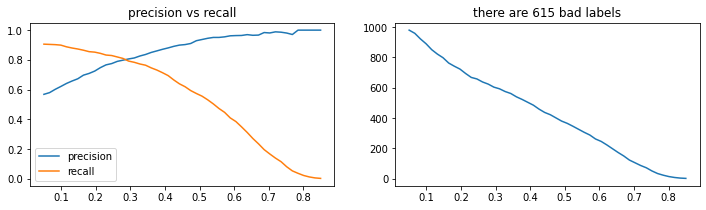

In [36]:
import matplotlib.pylab as plt

pltr = pd.DataFrame(data)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(pltr['threshold'], pltr['precision'], label="precision")
plt.plot(pltr['threshold'], pltr['recall'], label="recall")
plt.title(f"precision vs recall");
plt.legend()
plt.subplot(122)
plt.plot(pltr['threshold'], pltr['n'], label="precision")
plt.title(f"there are {(score_tbl['flip_label'] != score_tbl['label']).sum()} bad labels");

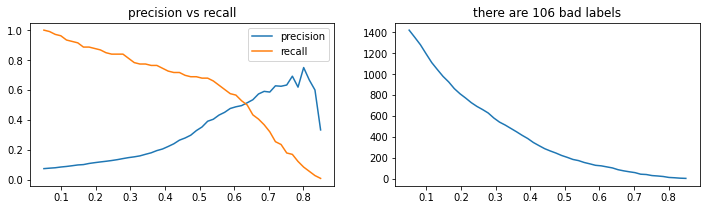

In [33]:
import matplotlib.pylab as plt

pltr = pd.DataFrame(data)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(pltr['threshold'], pltr['precision'], label="precision")
plt.plot(pltr['threshold'], pltr['recall'], label="recall")
plt.title(f"precision vs recall");
plt.legend()
plt.subplot(122)
plt.plot(pltr['threshold'], pltr['n'], label="precision")
plt.title(f"there are {(score_tbl['flip_label'] != score_tbl['label']).sum()} bad labels");